# Pre2post (Amdocs) with Pykhaos library
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Step 1) Set Paths and logger

DEVEL_SRC must be the directory that contains 'use-cases' and 'pykhaos'

In [7]:
import os, sys
import datetime as dt
DEVEL_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel")
if DEVEL_SRC not in sys.path:
    sys.path.append(DEVEL_SRC)

USECASES_SRC = os.path.join(DEVEL_SRC, "use-cases") # TODO when '-' is removed from name, remove also this line and adapt imports 
if USECASES_SRC not in sys.path: 
    sys.path.append(USECASES_SRC)
    
# AMDOCS_SRC = os.path.join(DEVEL_SRC, "amdocs_informational_dataset") # TODO when - is removed, remove also this line and adapt imports
# if AMDOCS_SRC not in sys.path: 
#     sys.path.append(AMDOCS_SRC)
    
import pykhaos.utils.custom_logger as clogger
logging_file = os.path.join(os.environ.get('BDA_USER_HOME', ''), "logging",
                                    "out_" + dt.datetime.now().strftime("%Y%m%d_%H%M%S") + ".log")
logger = clogger.configure_logger(log_filename=logging_file, std_channel=sys.stderr, logger_name="")
logger.info("Logging to file {}".format(logging_file))    
        
from project.project_generic import Project

import pykhaos.utils.notebooks as nb

import time
start_time = time.time()

RUNNING_FROM_NOTEBOOK = nb.isnotebook()
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
if RUNNING_FROM_NOTEBOOK:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline  
    EXTERNAL_LIB = os.path.join(os.environ.get('BDA_USER_HOME', ''), "lib", "external_libs")
    if EXTERNAL_LIB not in sys.path:
        sys.path.append(EXTERNAL_LIB)
    # feel free from commenting this line and the other ones that begin with "%%notify" if you do not have 
    # the extension installed or copy de lib from /var/SP/data/home/csanc109/lib/external_libs/jupyternotify/
    %load_ext jupyternotify 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

20190307-122848 [INFO ] Logging to file /var/SP/data/home/csanc109/logging/out_20190307_122848.log
20190307-122848 [DEBUG] $HOME=/home/csanc109
20190307-122848 [DEBUG] matplotlib data path /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/matplotlib/mpl-data
20190307-122848 [DEBUG] loaded rc file /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/matplotlib/mpl-data/matplotlibrc
20190307-122848 [DEBUG] matplotlib version 2.2.3
20190307-122848 [DEBUG] interactive is False
20190307-122848 [DEBUG] platform is linux2
20190307-122848 [DEBUG] loaded modules: ['_multiprocessing', 'IPython.core.error', 'ipython_genutils.py3compat', 'traitlets.config.sys', 'concurrent.futures.types', 'ipykernel.parentpoller', 'traitlets.config.decorator', 'ctypes.os', 'pexpect.select', 'runpy', 'gc', 'numpy.lib.numpy', 'pty', 'prompt_toolkit.terminal.vt100_output', 'prompt_toolkit.key_binding.six', 'dateutil.parser.dateutil', 'pygments.filters', 'IPython.utils.pprint', 'numpy.core.i

20190307-122848 [DEBUG] CACHEDIR=/home/csanc109/.cache/matplotlib
20190307-122848 [DEBUG] Using fontManager instance from /home/csanc109/.cache/matplotlib/fontList.json
20190307-122848 [DEBUG] backend agg version v2.2
20190307-122848 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown
20190307-122848 [DEBUG] backend module://ipykernel.pylab.backend_inline version unknown


<IPython.core.display.Javascript object>

# Step 2) Building the model

## Input Params [To be set by the user]

In [8]:
# Input data - hdfs file to build the training model
DP_FILENAME = "/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete"

# Choose one number here
H2O_PORT = 54124 # Be sure no instance running on this port!


## Constants [No edit required]

You do not need to change these constants and paths. 

However, you may need to edit these files:
* MODEL_YAML_PATH --> for changing the model training parameters
* XLSX_REPORT_TEMPLATE_PATH --> for changing the template of the reporter [only advanced users]

In [9]:

# This name is used when saving the model (Pickle object)
MODEL_NAME = "pre2post" # Results will be stored in a directory named like this

# Specify the primary key of the model - Usually, msisdn, num_cliente or nif
P_KEY = ["prepaid_msisdn"] 

# Configuration file for training the h2o model
MODEL_YAML_PATH = os.path.join(USECASES_SRC, "Pre2post_bdp", 'model', 'input', 'h2o_model.yaml')

# Yaml file of the template for building the excel file - do not modify unless you want to change the report 
XLSX_REPORT_TEMPLATE_PATH = os.path.join(USECASES_SRC, "Pre2post_bdp", 'model', 'input', 'xlsx_report_template.yaml')

# Save the root path for savings
SAVING_PATH = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "pre2post")

# Guarantee directoy is unique
UNIQUE_DIRNAME = dt.datetime.now().strftime("%Y%m%d_%H%M%S")

SAVING_PATH_UNIQUE = os.path.join(SAVING_PATH, "results", MODEL_NAME, UNIQUE_DIRNAME)

PROJECT_NAME = "pre2post"


## IMPORTS and INITIALIZATION [No edit required]

In [10]:
from pyspark.sql.functions import collect_set, concat, size, coalesce, col, lpad, struct, count as sql_count, lit, min as sql_min, max as sql_max, collect_list, udf, when
from pyspark.sql.types import StringType, ArrayType, MapType, StructType, StructField, IntegerType
from pyspark.sql.functions import array, regexp_extract
sys.path.append(os.path.join(os.environ.get('BDA_USER_HOME', ''), "src", "devel", "pykhaos", "external_lib"))
from pykhaos.modeling.model import Model
import yaml
#input_data = yaml.load(open(CCC_TRAIN_TEST_YAML))

Using h2o version 3.18.0.10


## Start H2O [No edit]

The only parameter you could want to set is the max_mem_size, but think first!

In [15]:
from pykhaos.modeling.h2o.h2o_functions import restart_cluster_loop
restart_cluster_loop(port=H2O_PORT, max_mem_size = "2G",  nthreads = 4) # 

Shutdown 3.18.0.10
H2O session _sid_9a6b closed.
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54124. connected.


H2O cluster uptime:,1 min 20 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,9 months and 13 days !!!
H2O cluster name:,H2O_from_python_csanc109_71ufno
H2O cluster total nodes:,1
H2O cluster free memory:,1.917 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


Done!
locked=True healthy=True
Shutdown 3.18.0.10
init 3.18.0.10
Checking whether there is an H2O instance running at http://localhost:54124..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.7.0_79"; Java(TM) SE Runtime Environment (build 1.7.0_79-b15); Java HotSpot(TM) 64-Bit Server VM (build 24.79-b02, mixed mode)
  Starting server from /opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpnWDDOb
  JVM stdout: /tmp/tmpnWDDOb/h2o_csanc109_started_from_python.out
  JVM stderr: /tmp/tmpnWDDOb/h2o_csanc109_started_from_python.err
  Server is running at http://127.0.0.1:54124
Connecting to H2O server at http://127.0.0.1:54124... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.10
H2O cluster version age:,9 months and 13 days !!!
H2O cluster name:,H2O_from_python_csanc109_bgpe48
H2O cluster total nodes:,1
H2O cluster free memory:,1.917 Gb
H2O cluster total cores:,56
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Done!
locked=False healthy=True
out of while


## Load Data [No edit]

In [16]:
%%notify -m "Pre2post: ended Pre2Postdata "

from Pre2post_bdp.model.data.pre2post_data import Pre2post_Data
data_abs_data_obj = Pre2post_Data(input_data=None, filename=DP_FILENAME, pkey_cols=P_KEY)

20190307-123123 [INFO ] ***** locked=False healthy=True
20190307-123123 [INFO ] Trying to import '/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete' hdfs=True parquet=False
20190307-123125 [INFO ] Trying to import hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete
20190307-123140 [ERROR] file hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete could not be found at node 0


HTTP 500 Server Error:
Server error water.api.HDFSIOException:
  Error: HDFS IO Failure: 
 accessed URI : hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete
 configuration: Configuration: core-default.xml, core-site.xml, mapred-default.xml, mapred-site.xml, yarn-default.xml, yarn-site.xml, hdfs-default.xml, hdfs-site.xml, /opt/cloudera/parcels/SPARK2/lib/spark2/conf/yarn-conf/core-site.xml
 java.io.IOException: Failed on local exception: java.io.IOException: Couldn't setup connection for csanc109@INTERNAL.VODAFONE.COM to vgddp349hr.dc.sedc.internal.vodafone.com/10.109.120.22:8020; Host Details : local host is: "vgddp387hr.dc.sedc.internal.vodafone.com/10.109.120.122"; destination host is: "vgddp349hr.dc.sedc.internal.vodafone.com":8020;
  Request: None



20190307-123140 [INFO ] Trying to import hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete
20190307-123153 [ERROR] file hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete could not be found at node 1


HTTP 500 Server Error:
Server error water.api.HDFSIOException:
  Error: HDFS IO Failure: 
 accessed URI : hdfs://vgddp350hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/df_all_201811_201811_M2_classical_complete
 configuration: Configuration: core-default.xml, core-site.xml, mapred-default.xml, mapred-site.xml, yarn-default.xml, yarn-site.xml, hdfs-default.xml, hdfs-site.xml, /opt/cloudera/parcels/SPARK2/lib/spark2/conf/yarn-conf/core-site.xml
 java.io.IOException: Failed on local exception: java.io.IOException: Couldn't setup connection for csanc109@INTERNAL.VODAFONE.COM to vgddp350hr.dc.sedc.internal.vodafone.com/10.109.120.23:8020; Host Details : local host is: "vgddp387hr.dc.sedc.internal.vodafone.com/10.109.120.122"; destination host is: "vgddp350hr.dc.sedc.internal.vodafone.com":8020;
  Request: None



20190307-123153 [ERROR] Data could not be obtained


SystemExit: 

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



<IPython.core.display.Javascript object>

In [17]:
data_abs_data_obj.data().types()

NameError: name 'data_abs_data_obj' is not defined

## FIT Model [No edit]

loaded '/var/SP/data/home/csanc109/src/devel/use-cases/Pre2post_bdp/model/input/h2o_model.yaml'
Using test_ratio_split=0.35
(0, 2379737)
(1, 10660)
H2O Engine :)
Using h2o version 3.18.0.10
**** FIT *****
drf Model Build progress: |███████████████████████████████████████████████| 100%


<IPython.core.display.Javascript object>


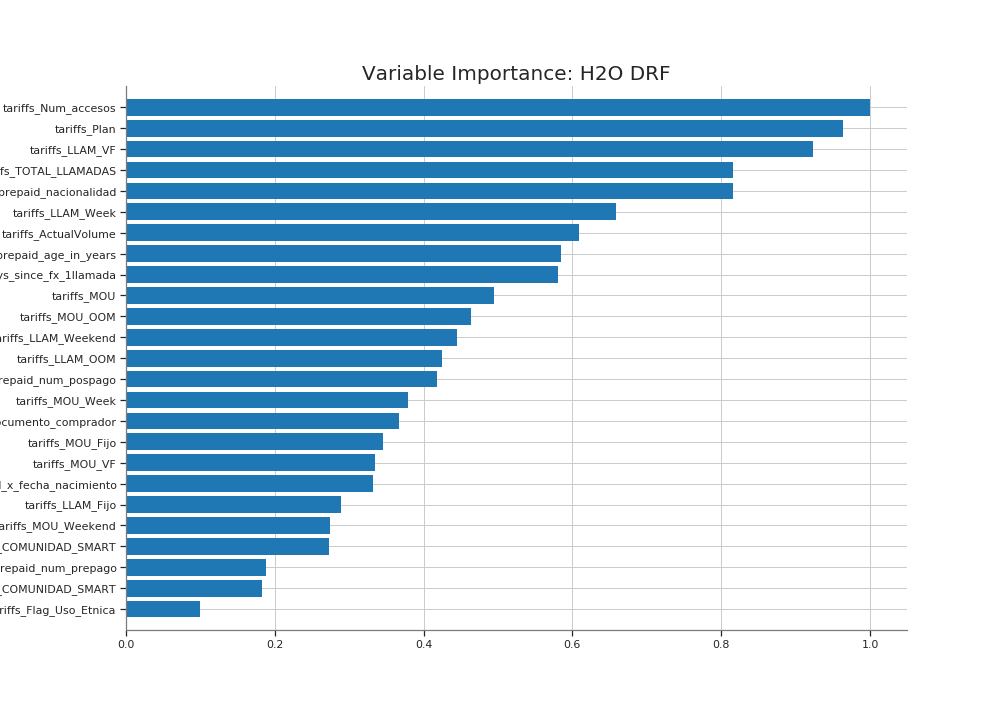

Time in fit method: 00:02:33
drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
* * * * * * * METRICS TRAIN * * * * * * * 


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [18]:
%%notify -m "pre2post_model_pykahos: ended fit "
modeler = Model(MODEL_NAME, MODEL_YAML_PATH, verbose=False)
modeler.fit(data_abs_data_obj)

## SAVE model [Optional]

Run this cell if you want the model in a file to use it later

In [19]:
%%notify -o

result="FAILED"

import datetime as dt
from churn.utils.constants import YAML_DATA_PREPARATION, YAML_CLOSING_DAY
save_model_path =  os.path.join(SAVING_PATH_UNIQUE, "model")
modeler.save(save_model_path)
result="OK"
"Pre2post_model_pykahos: [{}] model saved ".format(result)

************** model.py save
['model_fit_config', 'model_fit_params', 'numero_variables', 'target_freq', 'model train metrics', 'target_freq_split', 'test_partition_size', 'model_fit_score_hist', 'model test metrics', 'train_partition_size']
Starting save of model at '/var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/pre2post.pkl'
save h2o_factory /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model
save h2o_factory_saving_path /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/h2o_factory
Saved h2o model in path /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/h2o_factory/DRF_model_python_1551955416456_119
Saving object at /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/pre2post.pkl
Calling to __getstate model
saving_model_info
['model_fit_config', 'model_fit_params', 'numero_variables', 'target_freq', 'model train metrics', 'target_freq_

'Pre2post_model_pykahos: [OK] model saved '

<IPython.core.display.Javascript object>

## Reporter [Optional]

Run this section if you want to have a reporter with a summary of the training results

Reporter __init__ model_id=pre2post model_dir=/var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190225_092524/model template_yaml_path=/var/SP/data/home/csanc109/src/devel/use-cases/Pre2post_bdp/model/input/xlsx_report_template.yaml
Loading model /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190225_092524/model/pre2post.pkl
Loading object from /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190225_092524/model/pre2post.pkl
Calling to __setstate H2O Factory
['config', 'params', 'modeler_save_path', 'feature_importance']
Calling to __setstate in model
['model_id', 'model_info', 'yaml_filename', 'cols', 'cat_encoding', 'model']
Loaded modeler from path /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190225_092524/model/h2o_factory/Grid_GBM_py_54_sid_bdc8_model_python_1551083126984_1199_model_1
Loading report template from '/var/SP/data/home/csanc109/src/devel/use-cases/Pre2post_bdp/model/input/xlsx_report_template.yaml'


<IPython.core.display.Javascript object>


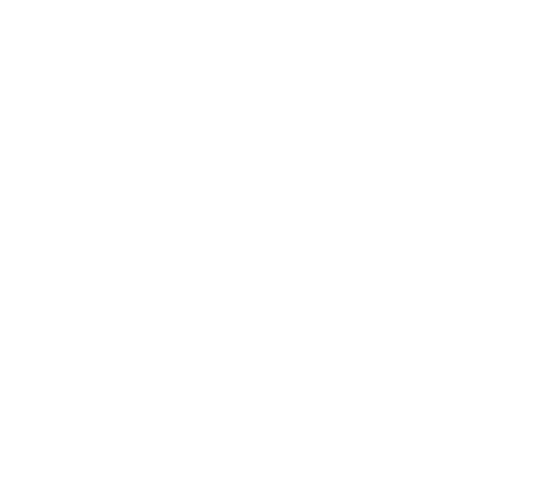

Figure(540x504)


<IPython.core.display.Javascript object>


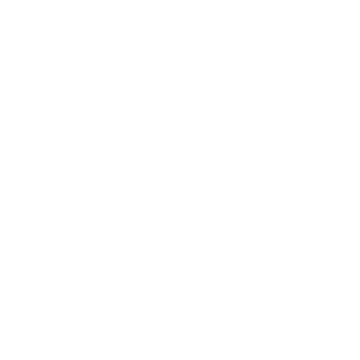

<IPython.core.display.Javascript object>


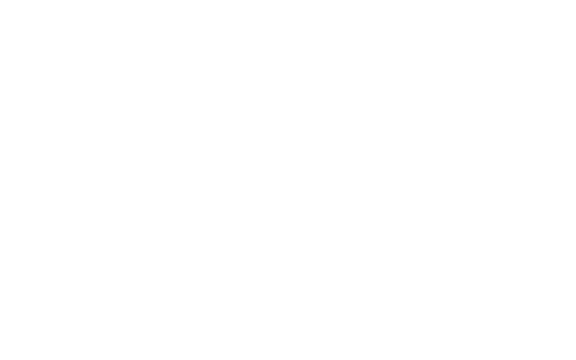

<IPython.core.display.Javascript object>


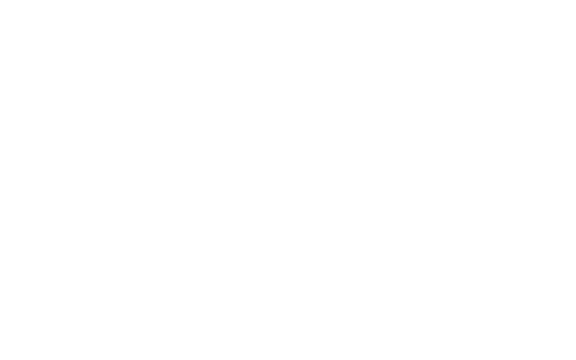

<IPython.core.display.Javascript object>


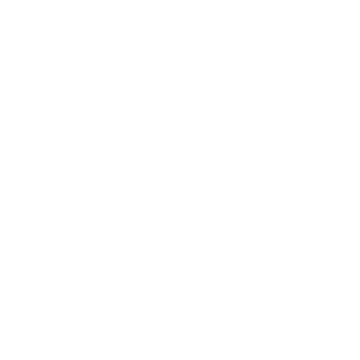

Writting sheet 'Intro'
Writting sheet 'Split'
Writting sheet 'Model'
Writting sheet 'Train metrics'


AttributeError: 'NoneType' object has no attribute 'print_figure'

<IPython.core.display.Javascript object>


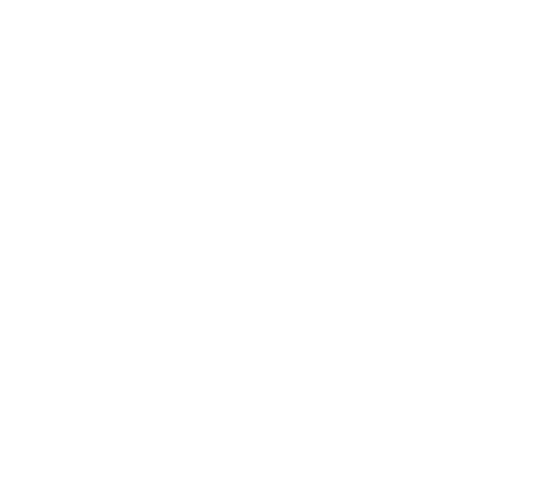

<IPython.core.display.Javascript object>


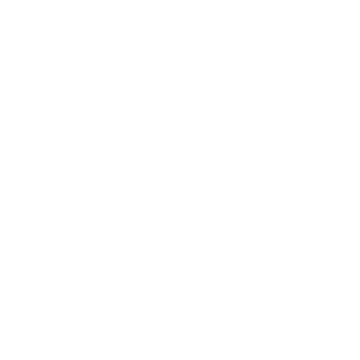

<IPython.core.display.Javascript object>


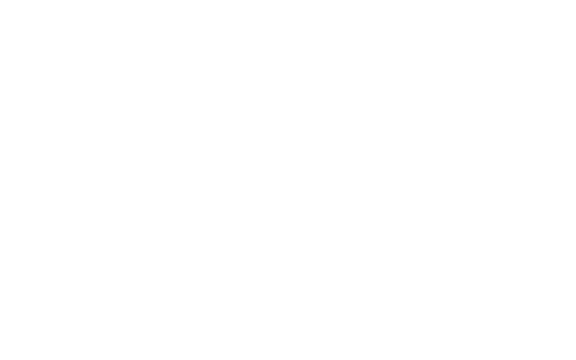

<IPython.core.display.Javascript object>


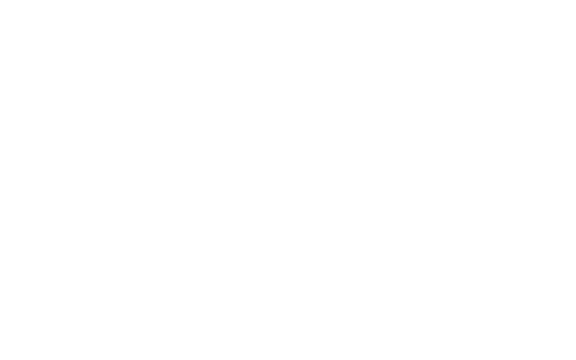

<IPython.core.display.Javascript object>


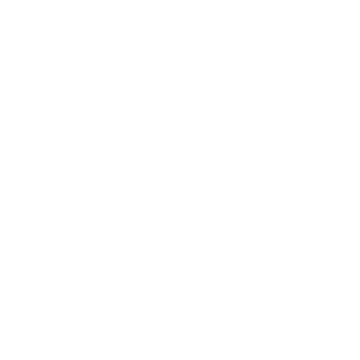

<IPython.core.display.Javascript object>

In [23]:
%%notify -o
result="FAILED"

from pykhaos.reporting.reporter import Reporter

save_reporter_path = os.path.join(SAVING_PATH_UNIQUE, "reporter")

reporter = Reporter(MODEL_NAME, save_model_path, XLSX_REPORT_TEMPLATE_PATH).set_saving_path(save_reporter_path).create()

print 'Informe generado!'

result="OK"
"Pre2post_model_pykhaos: [{}] reporter finished".format(result)

# Step 3) GENERATE PREDICTIONS

## Input Data

In [20]:
# - - - - - - - 
# INPUT DATA FOR PREDICTIONS
# Change these dates according to the predict yyyymm and the campaign label
predict_yyyymm = "201812"
FILE_FOR_PREDICT = '/user/csanc109/projects/pre2post/data/unlabeled/df_all_{0}_{0}_M2_classical_complete'.format(predict_yyyymm)

# The ~21st January, we deliver the list for the February campaign (201902)
CAMPAIGN_DATE = "201903"


# Set to variable 'MODEL_NAME' to use training model
PREDICT_MODEL_NAME = MODEL_NAME
# Set to variable 'save_model_path' to use the just trained model. Specify a path of a stored model to use it.
PREDICT_MODEL_PATH =  save_model_path #"/var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190121_213451/model" #save_model_path 




## Get Spark session [No edit]

In [12]:
import time
start_time = time.time()
app_name = "predictions_nb"

import pykhaos.utils.pyspark_configuration as pyspark_config
sc, spark, sql_context = pyspark_config.get_spark_session(app_name=app_name, log_level="OFF", min_n_executors = 1, max_n_executors = 10, n_cores = 4,
                         executor_memory = "16g", driver_memory="16g")
print("Ended spark session: {} secs | default parallelism={}".format(time.time() - start_time,
                                                                     sc.defaultParallelism))

Ended spark session: 35.3650650978 secs | default parallelism=2


## Get predictions dataframe  [No edit]

('pre2post', '/var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model')
Loading model /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/pre2post.pkl
Loading object from /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/pre2post.pkl


<IPython.core.display.Javascript object>


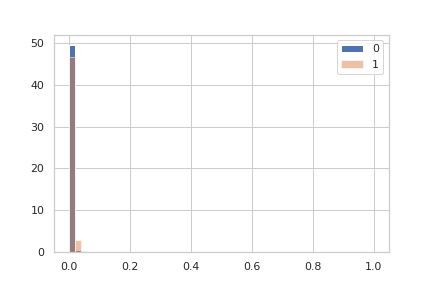

<IPython.core.display.Javascript object>


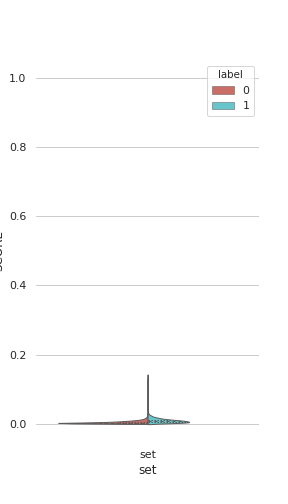

<IPython.core.display.Javascript object>


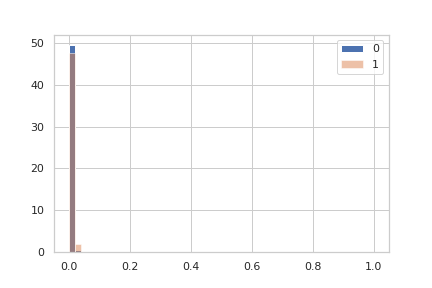

<IPython.core.display.Javascript object>


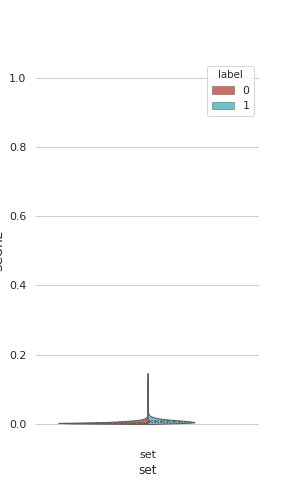

Calling to __setstate H2O Factory
['params', 'config', 'modeler_save_path', 'feature_importance']
Calling to __setstate in model
['model_id', 'model_info', 'yaml_filename', 'cols', 'cat_encoding', 'model']
Loaded modeler from path /var/SP/data/home/csanc109/data/pre2post/results/pre2post/20190307_114330/model/h2o_factory/GBM_model_python_1551955416456_1


20190307-115204 [INFO ] ***** locked=False healthy=True
20190307-115204 [INFO ] Trying to import '/user/csanc109/projects/pre2post/data/unlabeled/df_all_201812_201812_M2_classical_complete' hdfs=True parquet=False
20190307-115205 [INFO ] Trying to import hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/unlabeled/df_all_201812_201812_M2_classical_complete


Parse progress: |████████████████████████████████████████████████████████████████| 100%


20190307-115212 [INFO ] file hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/unlabeled/df_all_201812_201812_M2_classical_complete found at node 0


file hdfs://vgddp349hr.dc.sedc.internal.vodafone.com/user/csanc109/projects/pre2post/data/unlabeled/df_all_201812_201812_M2_classical_complete found at node 0
[u'prepaid_Fecha_ejecucion', u'prepaid_msisdn', u'prepaid_nacionalidad', u'prepaid_num_prepago', u'prepaid_num_pospago', u'prepaid_age_in_years', u'prepaid_tipo_documento_comprador', u'prepaid_x_fecha_nacimiento', u'prepaid_partitioned_month', u'prepaid_fx_1llamada', u'tariffs_MOU', u'tariffs_TOTAL_LLAMADAS', u'tariffs_TOTAL_SMS', u'tariffs_MOU_Week', u'tariffs_LLAM_Week', u'tariffs_SMS_Week', u'tariffs_MOU_Weekend', u'tariffs_LLAM_Weekend', u'tariffs_SMS_Weekend', u'tariffs_MOU_VF', u'tariffs_LLAM_VF', u'tariffs_SMS_VF', u'tariffs_MOU_Fijo', u'tariffs_LLAM_Fijo', u'tariffs_SMS_Fijo', u'tariffs_MOU_OOM', u'tariffs_LLAM_OOM', u'tariffs_SMS_OOM', u'tariffs_MOU_Internacional', u'tariffs_LLAM_Internacional', u'tariffs_SMS_Internacional', u'tariffs_ActualVolume', u'tariffs_Num_accesos', u'tariffs_Plan', u'tariffs_Num_Cambio_Planes', u

20190307-115214 [INFO ] df_h2o ready to be used!


gbm prediction progress: |████████████████████████████████████████████████| 100%


/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset is missing column 'prepaid_days_since_fx_1llamada': substituting in a column of NaN

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset column 'tariffs_Plan' has levels not trained on: [PPIB2, PPIB6, PPJ24, PPJAT, PPJMI, PPRE2, PPRE5, PPRES, PPRET, PPREY, PPVE1, PPVE2, PPVE3, PPVSP]

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/h2o/job.py:69: UserWarning:

Test/Validation dataset is missing column 'campaign_days_since_DATEID': substituting in a column of NaN



0.1434884648057942

In [17]:
local_dir_deliverables = '<local_dir>'
%matplotlib notebook

print(PREDICT_MODEL_NAME, PREDICT_MODEL_PATH)

from pykhaos.modeling.model import Model

modeler_predict = Model.load(PREDICT_MODEL_NAME, PREDICT_MODEL_PATH) # load the model
from churn.models.ccc.data.ccc_data import CCC_Data

summary_info = {}
df_list = None
from Pre2post_bdp.model.data.pre2post_data import Pre2post_Data

predict_ccc_data_obj = Pre2post_Data(filename=FILE_FOR_PREDICT, pkey_cols=["prepaid_msisdn"] , input_data=None) # generate obj
modeler_predict.predict(predict_ccc_data_obj) # predict

df_h2o_predict = predict_ccc_data_obj.data()

df_scored_hidden = df_h2o_predict[["prepaid_msisdn","SCORE"]].as_data_frame()
df_scored_hidden.rename(columns={"prepaid_msisdn" : "msisdn_hidden", "SCORE" : "score"}, inplace=True)

df_scored_hidden["score"].max()

## Plot scores [Optional]

Run this cell to have a plot of the scores. It is useful to check if the predictions were made properly

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


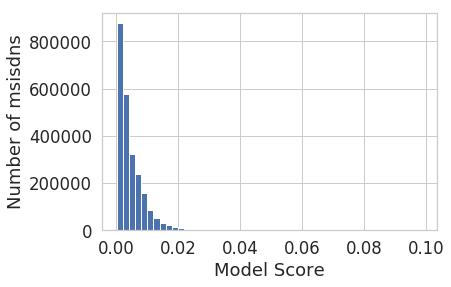

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

plt.figure()
n, bins, patches = plt.hist(df_scored_hidden["score"], bins=50)
plt.xlabel('Model Score')
plt.ylabel('Number of msisdns')
#plt.title(filename_pred)
plt.grid(True)
# #plt.show()

## Prepare delivery

Predictions are stored in a table, whose name is stored in variable 'name_table_anonymized'

### Save predictions in a table

In [17]:
project_name = PROJECT_NAME
campaign_date_label = CAMPAIGN_DATE
df_predictions = df_scored_hidden
from pykhaos.utils.constants import WHOAMI
from Pre2post_bdp.model.delivery.prepare_delivery import save_pred_as_table, desanonimizar, deliver_table

dir_download = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "download", project_name, "")
dir_delivery = os.path.join(os.environ.get('BDA_USER_HOME', ''), "data", "delivery", project_name, "")
name_table_anonymized = 'tests_es.{}_tmp_{}_{}_notprepared'.format(WHOAMI, project_name, campaign_date_label )
name_table_deanonymized = 'tests_es.{}_tmp_{}_{}_prepared'.format(WHOAMI, project_name, campaign_date_label )
name_file_delivery = '{}_delivery_{}_{}'.format(project_name, campaign_date_label ,
                                                dt.datetime.now().strftime("%Y%m%d_%H%M%S"))

print(name_table_anonymized,name_table_deanonymized,name_file_delivery)
save_pred_as_table(spark, df_predictions, name_table_anonymized)
logger.info("df_predictions saved as table '{}'".format(name_table_anonymized))


('tests_es.csanc109_tmp_pre2post_201903_notprepared', 'tests_es.csanc109_tmp_pre2post_201903_prepared', 'pre2post_delivery_201903_20190225_092827')


KeyboardInterrupt: 

### Deanonymized table

Take table created in previous step and deanonymize the msisdn

In [ ]:
# sh /var/SP/data/home/csanc109/src/desanonimizar_jsotovi2/desanonimizar_csanc109.sh --fields msisdn=DE_MSISDN --overwrite tests_es.csanc109_tmp_pre2post_201902_notprepared tests_es.csanc109_tmp_pre2post_201902_prepared
# If "desanonimizar" does not end, run the command line by hand in a Terminal. Remember to update the line with the proper table names.
spark.sql("refresh table {}".format(name_table_anonymized))
desanonimizar(name_table_anonymized,name_table_deanonymized)


### Create csv

In [ ]:
# Generate the delivery file (the csv we have to sent to Everis)
deliver_table(spark, name_table_deanonymized,name_file_delivery,dir_download,dir_delivery,local_dir_deliverables=None)